# Stroke prediction project

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. 

This dataset contains information about patients. Input parameters are gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

The **aim of this project** is to predict whether a given patient is likely to get stroke based on the input parameters.

## Imports

In [ ]:
import pandas as pd
import numpy as np
import kagglehub
import os
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from scipy import stats
from scipy.stats import skew, randint, uniform, normaltest
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
import iv_statistics as iv
from iv_statistics import GroupedMedianImputer, ColumnDropper

## Loading the dataset

### Download the dataset from Kaggle

In [2]:
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\inese\.cache\kagglehub\datasets\fedesoriano\stroke-prediction-dataset\versions\1


In [3]:
path = rf"{path}"
csv_file = "healthcare-dataset-stroke-data.csv"
file_path = os.path.join(path, csv_file)
print(file_path)
stroke_data = pd.read_csv(file_path, index_col=0)
np.set_printoptions(suppress=True)
print(f"There are {len(stroke_data)} rows in this dataset.")
stroke_data.head(5)

C:\Users\inese\.cache\kagglehub\datasets\fedesoriano\stroke-prediction-dataset\versions\1\healthcare-dataset-stroke-data.csv
There are 5110 rows in this dataset.


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Table contains following data:

1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

## Data cleaning

### Check feature data types

In [4]:
print(stroke_data.dtypes)

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


Fore these categoric features one-hot encoder will be used: gender, work_type, residence_type and smoking_status. For ever_married feature "Yes" will be replaced with "1", "No" - with "0". But before that I will explore more this dataset.

### Search for missing values

In [5]:
missing_values_per_column = stroke_data.isnull().sum()

print("Number of missing values par each column:")
print(missing_values_per_column)

Number of missing values par each column:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


There are 201 missing values for "bmi" feature, it is ~ 4% of the data. It is not much, so teoretically these rows could be removed from this dataset. I will decide later, first I have to check if this dataset is heavily imbalanced then it may not be good idea to remove any data.

Missing data may also include features with values "Unknown" or similar so let's check it.

In [6]:
categorical_columns = stroke_data.select_dtypes(include=['object', 'category', 'int64']).columns
for col in categorical_columns:
    print(f"{col}: {stroke_data[col].unique()} \n")

gender: ['Male' 'Female' 'Other'] 

hypertension: [0 1] 

heart_disease: [1 0] 

ever_married: ['Yes' 'No'] 

work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked'] 

Residence_type: ['Urban' 'Rural'] 

smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown'] 

stroke: [1 0] 



Only smoking_staus feature has values "Unknown". How many are there?

In [7]:
stroke_data[stroke_data['smoking_status'] == 'Unknown'].shape[0]

1544

There are quite a lot of unknown values, therefore these rows will not be removed and I will leave them as is, it may also represent certain patient group.


### Search for duplicate rows

In [8]:
duplicate_rows = stroke_data.duplicated(keep="first").sum()
print("There are", duplicate_rows, "duplicate rows in this dataset.")

There are 0 duplicate rows in this dataset.


I will also check if there are identical patient IDs. It is not good if same patient data goes both to training and test set. It can lead to data leakage.

In [9]:
stroke_data.index.duplicated().any()

np.False_

There are no duplicate patiend IDs in this dataset.

### Display summary statistics of numeric features

In [10]:
numeric_columns = stroke_data.select_dtypes(include=['float64']).columns
numeric_data = stroke_data[numeric_columns]
summary_statistics = numeric_data.describe()
summary_statistics

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


### Search for outliers

I will use boxplots to look at the distributions and outliers.

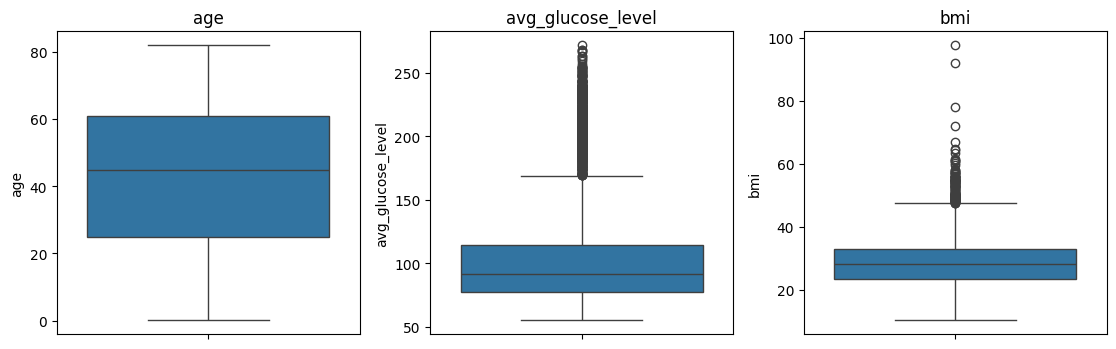

In [11]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_data):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=stroke_data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

Age range is credible, there children and elderly people among patients. Avg_glucose_level is right skewed with many patients having levels above normal. BMI is also right shewed, many patients are overwight, however, there also some patients that are underweight (BMI close to 10). All those values are credible, e.g. BMI world record is 204 (https://en.wikipedia.org/wiki/List_of_heaviest_people), so I assume that values around 100 are credible.

### Split dataset into training and test sets

In [12]:
X = stroke_data.drop(columns=["stroke"])
y = stroke_data["stroke"]

In [13]:
X_train, X_vt, y_train, y_vt = train_test_split(
    X, y, test_size=0.30, random_state=50, stratify=y
)
X_validation, X_test, y_validation, y_test = train_test_split(
    X_vt, y_vt, test_size=0.5, random_state=50, stratify=y_vt
)

## EDA

The aim of this EDA is to look for distributions of numeric and categorics variables, search relationships between all features. 

Check how many patients had stoke and how many did not have stroke.

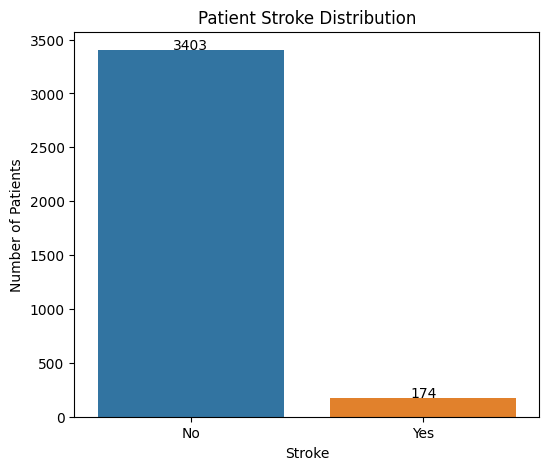

In [14]:
stroke_counts = y_train.value_counts()

plt.figure(figsize=(6, 5))
sns.barplot(x=stroke_counts.index, y=stroke_counts.values, hue=stroke_counts.index)
plt.xlabel("Stroke")
plt.ylabel("Number of Patients")
plt.title("Patient Stroke Distribution")
plt.xticks([0, 1], ["No", "Yes"])
for i, count in enumerate(stroke_counts.values):
    plt.text(i, count + 10, str(count), ha="center", fontsize=10)
plt.legend().remove()
plt.show()

We can see that small part of patients had stroke. This points to class imbalance, some classifiers, e.g. decision trees, tend to favor majority class. I will use balanced class weights in my baseline model.

Plot the distribution of the target variable (y_train) only for the rows where a BMI feature has NaN values.

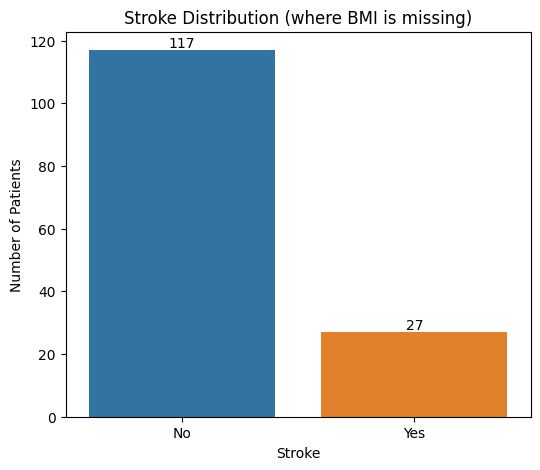

In [15]:
nan_mask = X_train['bmi'].isna()
stroke_counts_nan = y_train[nan_mask].value_counts()
plt.figure(figsize=(6, 5))
sns.barplot(x=stroke_counts_nan.index, y=stroke_counts_nan.values, hue=stroke_counts_nan.index)
plt.xlabel("Stroke")
plt.ylabel("Number of Patients")
plt.title("Stroke Distribution (where BMI is missing)")
plt.xticks([0, 1], ["No", "Yes"])
for i, count in enumerate(stroke_counts_nan.values):
    plt.text(i, count + 1, str(count), ha="center", fontsize=10)
plt.legend().remove()
plt.show()

We can see that a larger proportion of patients with missing BMI information had a stroke compared to the overall training dataset. Since this group—patients who had a stroke—is already underrepresented, retaining these 27 patients in our training data could be beneficial. Therefore I decide not to remove patients with missing BMI data, but impute missing values using median (because of many outliers in BMI data) grouped by gender and age bins. I will use this imputer for EDA only and for modelling I will implement imputer into pipeline.

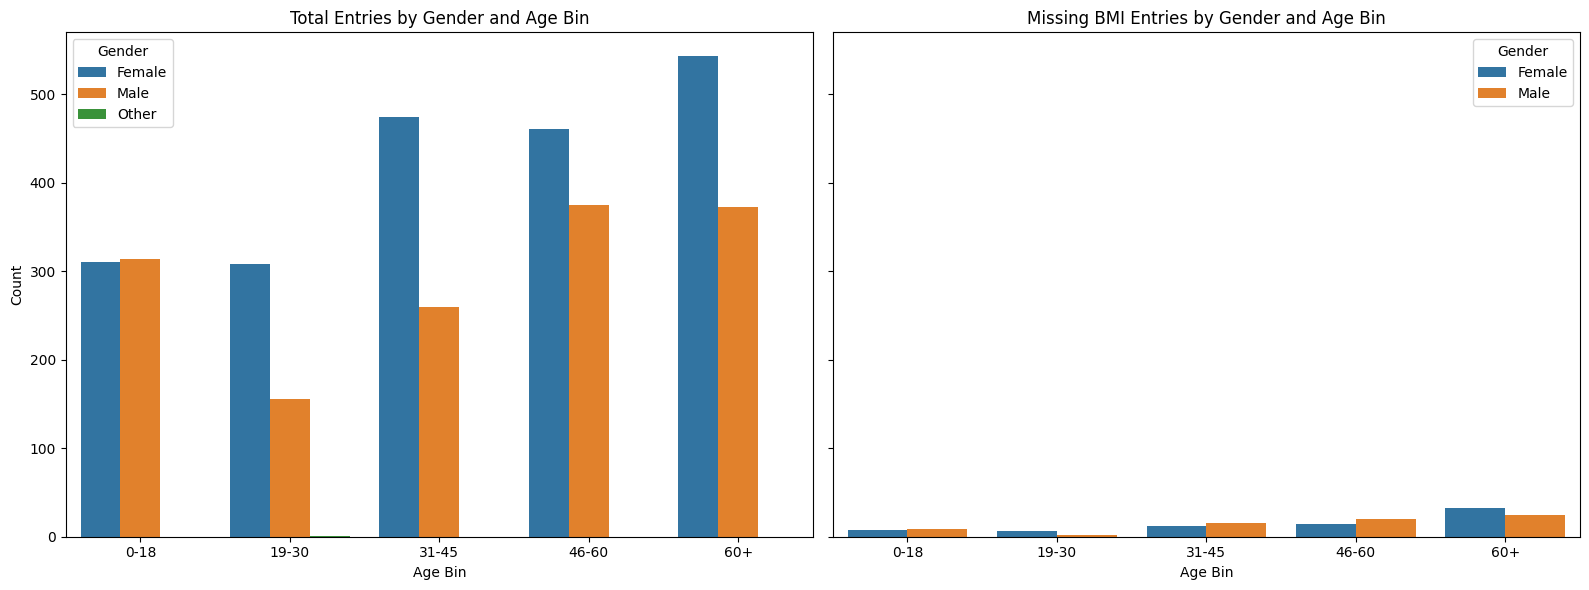

In [17]:

X_train['Age_bin'] = pd.cut(X_train['age'], bins=[0, 18, 30, 45, 60, 100], labels=['0-18', '19-30', '31-45', '46-60', '60+'])

X_train_imputed = X_train.copy()

group_counts = X_train_imputed.groupby(['gender', 'Age_bin'], observed=False).size().reset_index(name='count')

missing_bmi = X_train_imputed[X_train_imputed['bmi'].isna()]
missing_counts = missing_bmi.groupby(['gender', 'Age_bin'], observed=False).size().reset_index(name='missing_count')

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.barplot(data=group_counts, x='Age_bin', y='count', hue='gender', ax=axes[0])
axes[0].set_title('Total Entries by Gender and Age Bin')
axes[0].set_xlabel('Age Bin')
axes[0].set_ylabel('Count')
axes[0].legend(title='Gender')

sns.barplot(data=missing_counts, x='Age_bin', y='missing_count', hue='gender', ax=axes[1])
axes[1].set_title('Missing BMI Entries by Gender and Age Bin')
axes[1].set_xlabel('Age Bin')
axes[1].set_ylabel('')
axes[1].legend(title='Gender')

plt.tight_layout()
plt.show()

In [18]:
X_train_imputed['bmi'] = X_train_imputed.groupby(['gender', 'Age_bin'], observed=False)['bmi'].transform(lambda x: x.fillna(x.median()))

Plot numeric features by whether patient had stroke.

In [19]:
X_train = X_train.drop(columns=['Age_bin'])

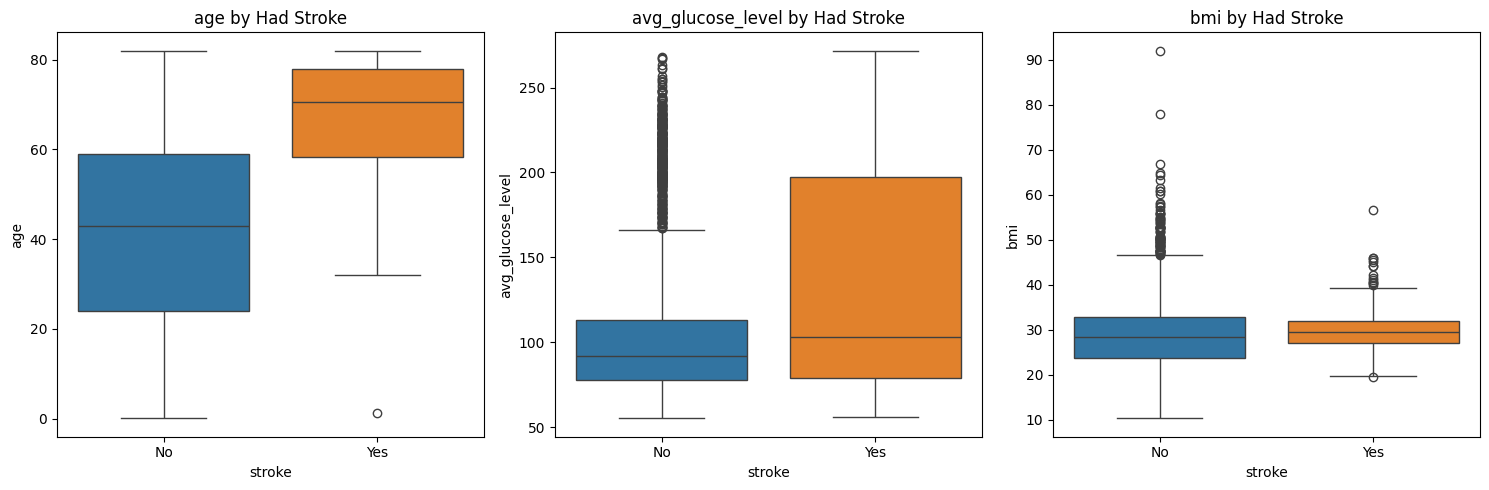

In [20]:
numeric_train = X_train_imputed[numeric_columns]

plt.figure(figsize=(15, 5))
for i, feature in enumerate(numeric_train.columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=y_train, y=numeric_train[feature], hue = y_train)
    plt.title(f"{feature} by Had Stroke")
    plt.xticks([0, 1], ["No", "Yes"])
    plt.legend().remove()
plt.tight_layout()
plt.show()

Age significantly impacts possibility of having stroke, also average glucose level does. BMI probably will not be so significant factor in predicting stroke.

Inspect histograms of numeric variables.

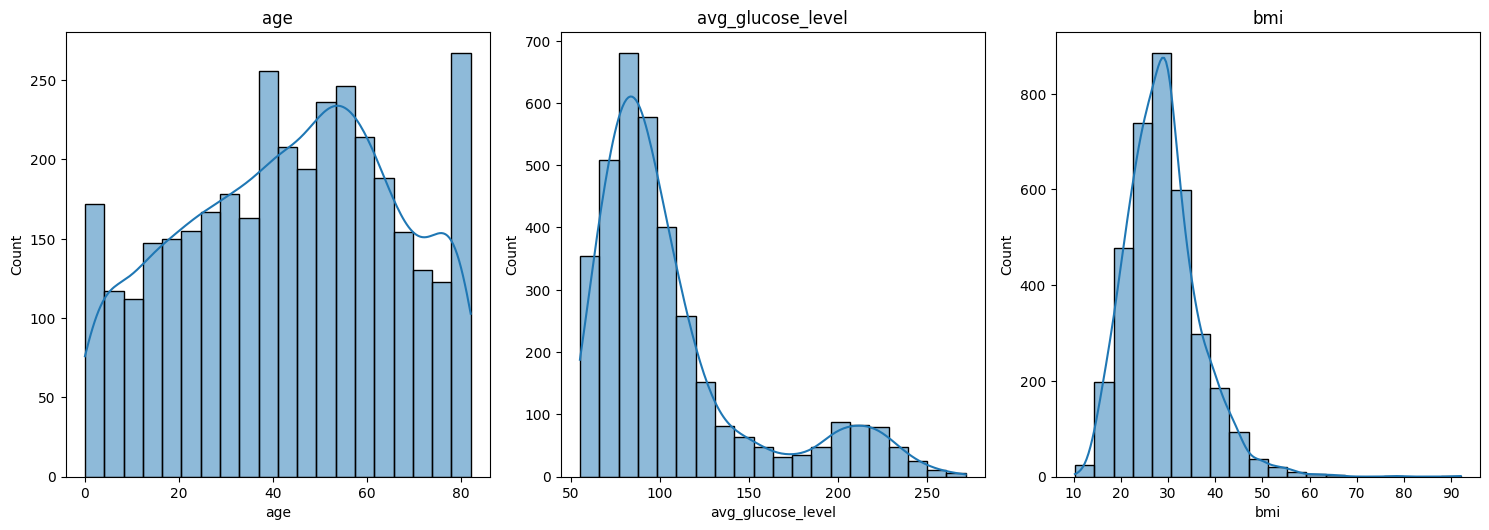

In [21]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_train.columns):
    plt.subplot(2, len(numeric_train.columns), i + 1)
    sns.histplot(X_train_imputed[feature], bins=20, kde=True)
    plt.title(f"{feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

Age is quite equally distributed, with slight peak around 55. Average glucose level appears to be slightly bimodal (~80 and ~210) and is right skewed. BMI is quite normally distributed but slightly right skewed.

Check for skeweness. A high skewness value (typically >1 or <-1) indicates that a feature is highly skewed and may benefit from log transformation.

In [147]:
skewness_values = numeric_train.apply(skew)

print("Skewness Scores:")
print(skewness_values.sort_values(ascending=False))

Skewness Scores:
avg_glucose_level    1.568302
bmi                  0.957931
age                 -0.139223
dtype: float64


Glucose level is significantly skewed.

Check for normality of data. I will use normaltest to do that, it is suited for size of this dataset.

In [148]:
for numeric_feature in numeric_columns:
    stat, p = normaltest(X_train_imputed[numeric_feature])
    print(f"{numeric_feature}: p = {p:.4f} → {'Normal' if p > 0.05 else 'Not normal'}")

age: p = 0.0000 → Not normal
avg_glucose_level: p = 0.0000 → Not normal
bmi: p = 0.0000 → Not normal


Numeric data is not normally distributed according to normaltest. I will consider it during statistical inference when choosing test.

Plot categoric variables with respect to target variable.

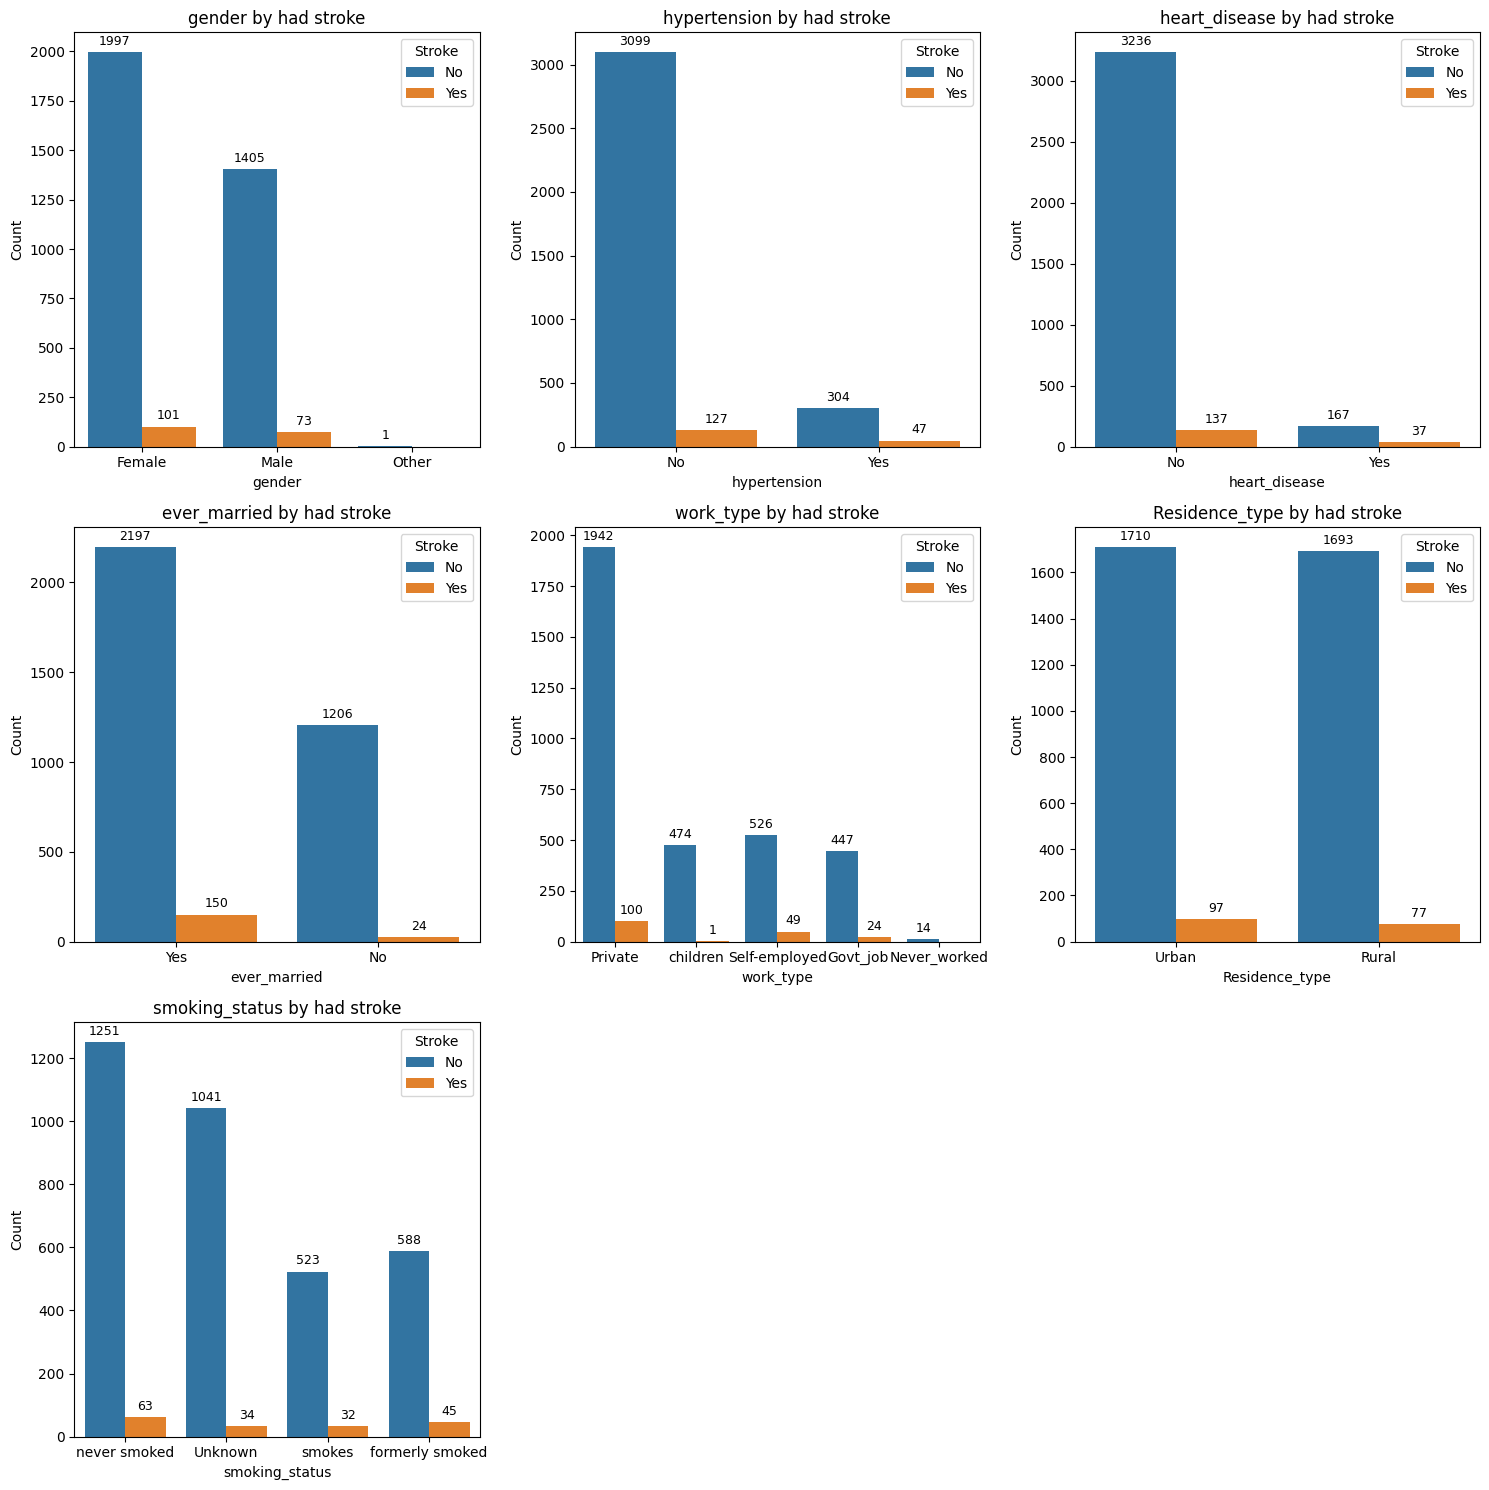

In [22]:
categorical_columns = [col for col in categorical_columns if col != 'stroke']
plt.figure(figsize=(15, 15))
for i, feature in enumerate(categorical_columns, 1):
    ax = plt.subplot(3, 3, i)
    sns.countplot(data=X_train, x=feature, hue=y_train, ax=ax)
    unique_vals = sorted(X_train[feature].dropna().unique())
    if set(unique_vals) == {0, 1}:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["No", "Yes"])
    ax.set_title(f"{feature} by had stroke")
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")
    ax.legend(title="Stroke", labels=["No", "Yes"])
    for p in ax.patches:
        height = p.get_height()
        x_pos = p.get_x() + p.get_width() / 2.
        if height > 0:
            ax.annotate(
                f'{int(height)}',
                (x_pos, height),
                ha='center', va='bottom',
                fontsize=9,
                xytext=(0, 3),
                textcoords='offset points'
            )
plt.tight_layout()
plt.show()

We see that among patients there are more females, most patients do not have hypertension and heart disease, largest part have been married, are working in private sector, both rural and urban residence types are almost equally represented, and most patients have never smoked or their smoking staus is unknown. 

Based on these visualizations, it appears that males and females have a similar likelihood of experiencing a stroke. However, patients with hypertension seem to have over three times the stroke rate compared to those without it. Those with heart disease appear to have five times the stroke rate. Married individuals also seem to have more than three times the stroke rate compared to those who are not married. Patients who are self-employed show a higher incidence of stroke as well.

Urban residents appear to have a slightly higher stroke rate than those in rural areas. Smoking status does not show a strong association with stroke in these plots, although those who currently or previously smoked seem to have a marginally higher stroke rate.

Use one-hot encoding for categoric features to convert them to numeric form.

In [23]:
ohe_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
other_features = [col for col in X_train_imputed.columns if col not in ohe_features]
encoder = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')

X_train_ohe = encoder.fit_transform(X_train_imputed[ohe_features])

encoded_feature_names = encoder.get_feature_names_out(ohe_features)
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=encoded_feature_names, index=X_train.index)

X_train_encoded = pd.concat([X_train_imputed[other_features], X_train_ohe_df], axis=1)

In [151]:
pd.set_option('display.max_columns', None)
X_train_encoded.head(5)

,age,hypertension,heart_disease,avg_glucose_level,bmi,Age_bin,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,,,,,,,
12807,63.0,1,0,81.54,24.2,60+,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9511,27.0,0,0,119.67,36.9,19-30,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5655,4.0,0,0,83.13,16.8,0-18,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
9122,25.0,0,0,89.87,26.5,19-30,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
47600,47.0,0,0,96.04,29.2,46-60,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


Compute correllations between all variables. I will use Pearson correllation between numeric variables, Spearman correllation between categorical variables, and point-biserial correlation between numeric and categoric variables. For that I will first drop one of one-hot encoded features to avoid multicollinearity. Then I will combine correllations in one correlation matrix and plot a heatmap.

In [24]:
categorical_ohe = ['hypertension', 'heart_disease', 'gender_Male', 'gender_Other', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked',	'smoking_status_smokes']
combined_corr_df, corr_matrix = iv.calculate_combined_correlations(
    X_train_encoded,
    y_train,
    numeric_features=numeric_train.columns.tolist(),
    categorical_features=categorical_ohe,
)

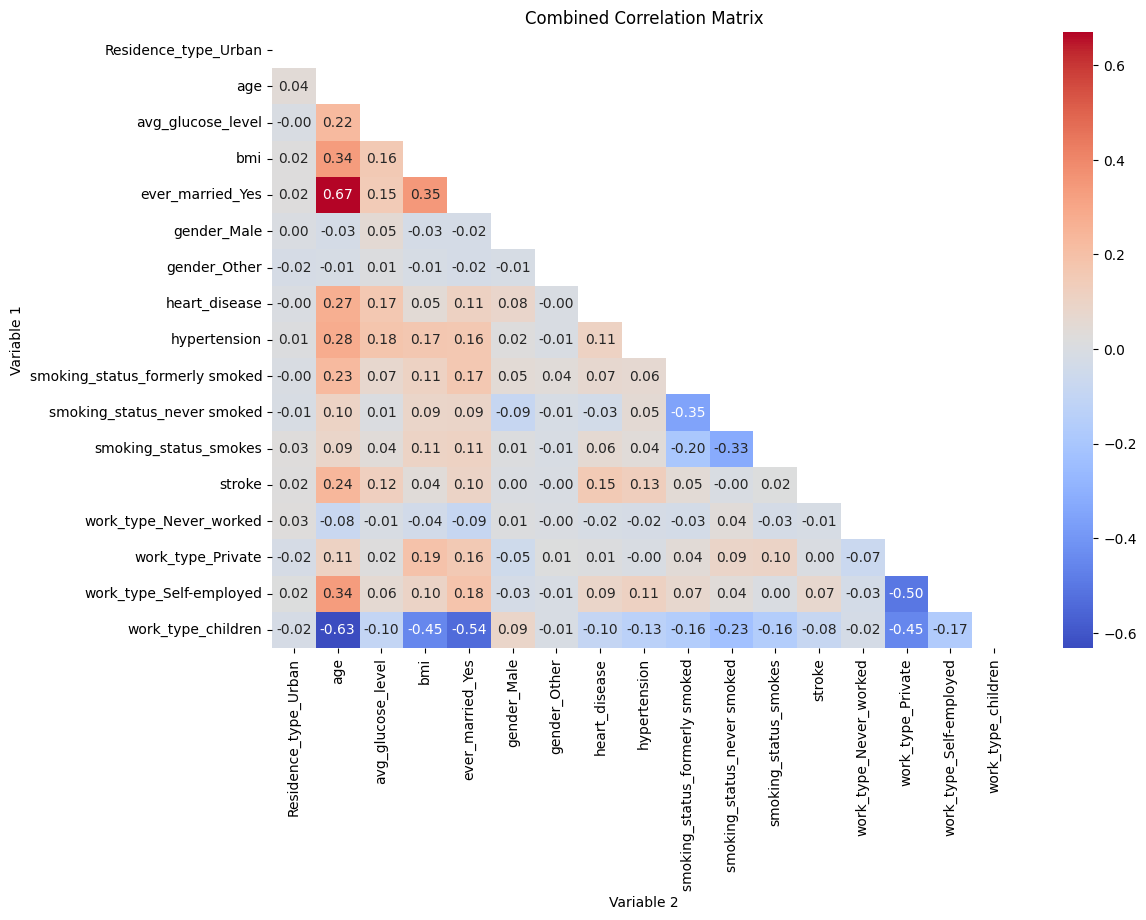

In [153]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", mask=np.triu(corr_matrix)
)
plt.title("Combined Correlation Matrix")
plt.show()

We can see slight positive correllation between age of patient and if he/she has ever been married and also negative correllation between age and work type - staying home with children. Having stroke has near zero correllation with all features.

Check multicollinearity using Variance Inflation factor (VIF) values. In case of multicollinearity, two or more predictor variables in a regression model are highly correlated.

In [154]:
X_subset = X_train_encoded[categorical_ohe]

vif_data = pd.DataFrame()
vif_data["Feature"] = X_subset.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_subset.values, i)
    for i in range(len(X_subset.columns))
]

print(vif_data)

                           Feature       VIF
0                     hypertension  1.165836
1                    heart_disease  1.102091
2                      gender_Male  1.676823
3                     gender_Other  1.003107
4                 ever_married_Yes  3.435345
5           work_type_Never_worked  1.017968
6                work_type_Private  3.119991
7          work_type_Self-employed  1.723204
8               work_type_children  1.242830
9             Residence_type_Urban  1.898920
10  smoking_status_formerly smoked  1.718585
11     smoking_status_never smoked  2.260437
12           smoking_status_smokes  1.603905


No VIF values higher than 5, there is no multicollinearity.

## Statistical inference

**Target population** are patients, having potential risk of stroke.

**Hypothesis**

1. Testing if Age affects risk having stroke

Null Hypothesis: There is no significant difference in the mean age between patients who had stroke and those who hadn't.

Alternative Hypothesis: There is a significant difference in the mean age between patients who had stroke and those who hadn't.

2. Testing if being married affects risk having stroke

Null Hypothesis: There is no association between being married and whether the patient had stroke.

Alternative Hypothesis: There is an association between tbeing married and whether the patient had stroke.

3. Testing if BMI affects risk having stroke

Null Hypothesis: There is no significant difference in the mean BMI between patients who had stroke and those who hadn't.

Alternative Hypothesis:  There is a significant difference in the mean BMI between patients who had stroke and those who hadn't.

I choose **significance Level (α)** to be 0.05 (5%), meaning there’s a 5% chance of rejecting the null hypothesis when it is actually true.

**Test 1st hypothesis** if age affects risk having stroke. I will perform Mann–Whitney U test for two independent groups, because data was not normally distributed.

In [155]:
age_stat = iv.compare_means_mannwhitney(X_train_encoded, y_train, "age")

age Mann–Whitney U-statistic: 491716.50, P-value: 0.000
age Estimated 95% CI for median difference: (24.00, 31.00)


The difference in age distributions between stroke and non-stroke patients is statistically significant. We can reject the null hypothesis, which assumed both groups had similar age distributions. CI suggests that, on average, stroke patients are between 24 and 31 years older than non-stroke patients (based on medians).

**Test 2nd hypothesis** if ever being married is associated with having stroke. I will use Chi-Square test for association between ever_married_Yes (binary variable) and Stroke.

In [156]:
married_stat = iv.compare_proportions_chi2(X_train_encoded, y_train, "ever_married_Yes")

ever_married_Yes Chi2 Statistic: 33.42, P-value: 0.000
ever_married_Yes 95% CI for Proportion Difference: (0.163, 0.270)


The association between being married (ever_married_Yes) and having had a stroke is statistically significant. Proportion of stroke cases differs meaningfully between those who have and have not been married. CI means that married individuals are 16.3% to 27.0% more likely to have had a stroke, compared to non-married individuals (in terms of proportion difference). This could be confounded by age — older people are both more likely to be married and to have strokes.

**Test 3rd hypothesis** if BMI affects risk having stroke. Again, I will perform Mann–Whitney U test for two independent groups, because data was not normally distributed.

In [157]:
bmi_stat = iv.compare_means_mannwhitney(X_train_encoded, y_train, "bmi")

bmi Mann–Whitney U-statistic: 336830.50, P-value: 0.002
bmi Estimated 95% CI for median difference: (0.65, 1.50)


There's a significant difference in BMI between patients who had a stroke vs. those who didn’t (p < 0.05). We can reject the null hypothesis that BMI distributions are the same in both groups. CI indicates that, on average, stroke patients have a BMI that's about 0.65 to 1.50 units higher than non-stroke patients, based on median values. Although statistically significant, the difference is quite small in practical terms — a ~1 unit BMI difference may not be clinically impactful on its own.

## Model fitting

### Baseline model

As a baseline model I choose logistic regression model with default parameters, except, as I decided earlier, I will use balanced class weights to address class imbalance. Logistic regression is a good choice as a baseline model for binary classification tasks like predicting whether a patient had a stroke (had_stroke: 0 or 1).

Into preprocessing pipeline I will include scaling and one-hot encoding, and impute missing BMI values.

In [26]:
numeric_features = ['age', 'bmi', 'avg_glucose_level']
categorical_features = ['hypertension', 'heart_disease', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
X_train['age_bin'] = pd.cut(X_train['age'], bins=[0, 18, 30, 45, 60, 100], labels=['0-18', '19-30', '31-45', '46-60', '60+'])
X_validation['age_bin'] = pd.cut(X_validation['age'], bins=[0, 18, 30, 45, 60, 100], labels=['0-18', '19-30', '31-45', '46-60', '60+'])
X_test['age_bin'] = pd.cut(X_test['age'], bins=[0, 18, 30, 45, 60, 100], labels=['0-18', '19-30', '31-45', '46-60', '60+'])

In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

baseline = Pipeline(steps=[
    ('imputer', GroupedMedianImputer(group_cols=['gender', 'age_bin'], target_col='bmi')),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=50))
])

baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_validation)

print(classification_report(y_validation, y_pred))

C:\Users\inese\AppData\Local\Temp\ipykernel_6412\3894155599.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.group_medians_ = X.groupby(self.group_cols)[self.target_col].median()


              precision    recall  f1-score   support

           0       0.99      0.75      0.85       729
           1       0.14      0.81      0.24        37

    accuracy                           0.75       766
   macro avg       0.56      0.78      0.55       766
weighted avg       0.95      0.75      0.82       766



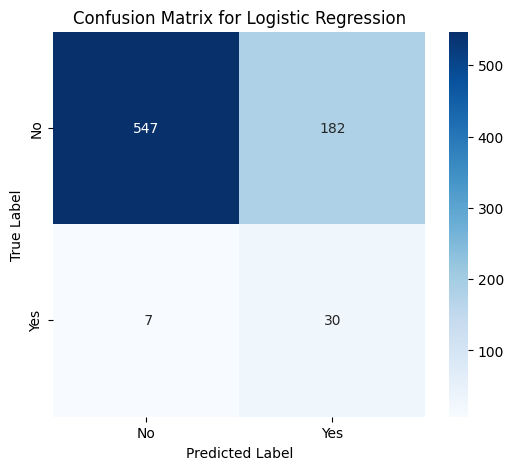

In [161]:
iv.plot_confusion(y_validation, y_pred, model_name="Logistic Regression")

As a main metric I choose recall, because it is very important to detect as many patients with stroke as possible. Recall score in this case is 0.81, from 37 patients with stroke, 30 were predicted correctly by baseline linear regression model. I think it is a very good result for baseline model. Let's see if non-linear models can predict patients with stroke better.

### Decision trees

I will start modellin with simple decision tree model. I will do preprocessing, hyperparameter tuning 

In [28]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

In [ ]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline(steps=[
    ('imputer', GroupedMedianImputer(group_cols=['gender', 'age_bin'], target_col='bmi')),
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=50, class_weight='balanced'))
])

param_distributions = {
    'classifier__max_depth': randint(2, 25),
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(2, 50),
    'classifier__criterion': ['gini', 'entropy']
}

random_search_dtree = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='recall',
    cv=stratified_cv,
    random_state=50,
    n_jobs=-1
)

random_search_dtree.fit(X_train, y_train)

print("Best parameters:", random_search_dtree.best_params_)
best_model = random_search_dtree.best_estimator_

C:\Users\inese\AppData\Local\Temp\ipykernel_4012\3894155599.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 13, 'classifier__min_samples_split': 7}


In [163]:
results_df = pd.DataFrame(random_search_dtree.cv_results_)
param_cols = [col for col in results_df.columns if col.startswith('param_')]
iv.plot_parallel_coordinates(results_df, dimensions=param_cols)

We can see best recall 0.89 for very shallow tree. It already outperforms logistic regression model. Test best decision tree model on validation dataset.

In [164]:
best_dtree_model = random_search_dtree.best_estimator_
y_pred_validation_dtree = iv.evaluate_on_validation(
    best_dtree_model, X_validation, y_validation
)


Validation (or Test) Set Performance:
Accuracy: 0.6723
Recall: 0.9189
F1 Score: 0.2132


Validation shows even better results for recall score (0.92) as for baseline model. Plot confusion matrix for best decision tree model.

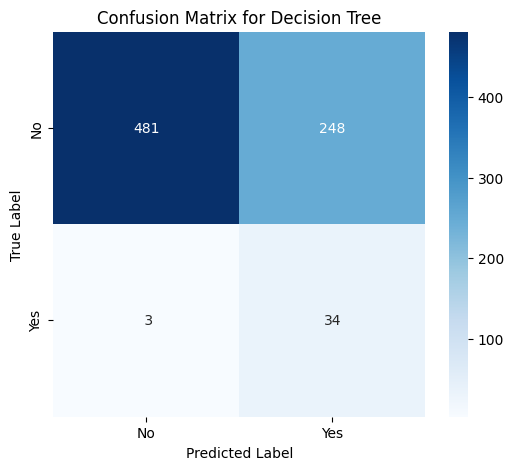

In [165]:
iv.plot_confusion(y_validation, y_pred_validation_dtree, model_name="Decision Tree")

We can see that there are 4 more correct predictions on the validation dataset compared to the logistic regression model. However, the number of false positives is significantly higher, which could be problematic—many patients without stroke risk may be unnecessarily subjected to health checks.

### Support Vector Machines (SVM) classifier

SVMs work by finding a hyperplane that best separates data points into different classes.

If the data is not linearly separable, a kernel trick (radial basis function, polynomial, etc.) can be used to map data into a higher-dimensional space, making it possible to find a hyperplane that separates the classes. SVM is sensitive to the scale of the input features because it relies on distance calculations, so I will use scaled data again. SVM assumes that the data points are independent and identically distributed. SVM can be sensitive to outliers which is not considered now, because there are no outliers in this dataset. SVM can handle class imbalance by adjusting the class weights so I will set it already before tuning.

In [166]:
pipeline = Pipeline(steps=[
    ('imputer', GroupedMedianImputer(group_cols=['gender', 'age_bin'], target_col='bmi')),
    ('preprocessor', preprocessor),
    ('classifier', SVC(class_weight='balanced', probability=True, random_state=50))  # enable probabilities if needed
])

param_distributions = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto'], 
    'classifier__degree': randint(2, 5)
}

random_search_svm = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='recall',
    cv=stratified_cv,
    random_state=50,
    n_jobs=-1
)

random_search_svm.fit(X_train, y_train)

print("Best parameters:", random_search_svm.best_params_)
best_model = random_search_svm.best_estimator_

C:\Users\inese\AppData\Local\Temp\ipykernel_4012\3894155599.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Best parameters: {'classifier__C': 0.1, 'classifier__degree': 4, 'classifier__gamma': 'auto', 'classifier__kernel': 'sigmoid'}


In [167]:
results_df = pd.DataFrame(random_search_svm.cv_results_)
param_cols = [col for col in results_df.columns if col.startswith('param_')]
iv.plot_parallel_coordinates(results_df, dimensions=param_cols)

In [168]:
best_svm_model = random_search_svm.best_estimator_
y_pred_validation_svm = iv.evaluate_on_validation(
    best_svm_model, X_validation, y_validation
)


Validation (or Test) Set Performance:
Accuracy: 0.7037
Recall: 0.8649
F1 Score: 0.2199


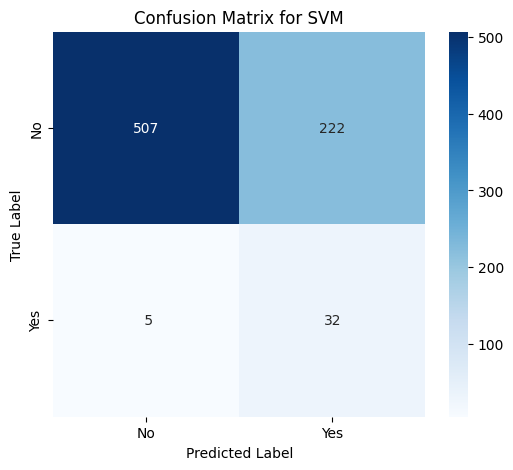

In [169]:
iv.plot_confusion(y_validation, y_pred_validation_svm, model_name="SVM")

### Random Forest

Because decision tree gave good recall score, I will try Random Forest classification. 

Random Forests are an ensemble learning method that operate by constructing multiple decision trees during training time and outputting the class that is the mode of the classes (for classification) predicted by individual trees.
Unlike individual decision trees, which can easily overfit, Random Forests reduce variance by averaging the results over many trees. This makes them generally more robust and better at generalizing to unseen data. Random Forest does not assume linearity, independence of features, or any particular distribution of the data. In hyperparameter tuning I will include:
n_estimators: number of trees in the forest, max_depth: limiting depth can prevent overfitting, min_samples_leaf: control the minimum number of samples required to be at a leaf node.

In [170]:
pipeline = Pipeline(steps=[
    ('imputer', GroupedMedianImputer(group_cols=['gender', 'age_bin'], target_col='bmi')),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=50))
])

param_distributions = {
    'classifier__n_estimators': randint(100, 500), 
    'classifier__max_depth': randint(2, 15),
    'classifier__min_samples_leaf': randint(1, 10)
}

random_search_rf = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='recall',
    cv=stratified_cv,
    random_state=50,
    n_jobs=-1
)

random_search_rf.fit(X_train, y_train)

print("Best parameters:", random_search_rf.best_params_)
best_model = random_search_rf.best_estimator_

C:\Users\inese\AppData\Local\Temp\ipykernel_4012\3894155599.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Best parameters: {'classifier__max_depth': 2, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 252}


In [171]:
results_df = pd.DataFrame(random_search_rf.cv_results_)
param_cols = [col for col in results_df.columns if col.startswith('param_')]
iv.plot_parallel_coordinates(results_df, dimensions=param_cols)

In [172]:
best_rf_model = random_search_rf.best_estimator_
y_pred_validation_rf = iv.evaluate_on_validation(
    best_rf_model, X_validation, y_validation
)


Validation (or Test) Set Performance:
Accuracy: 0.6815
Recall: 0.8919
F1 Score: 0.2129


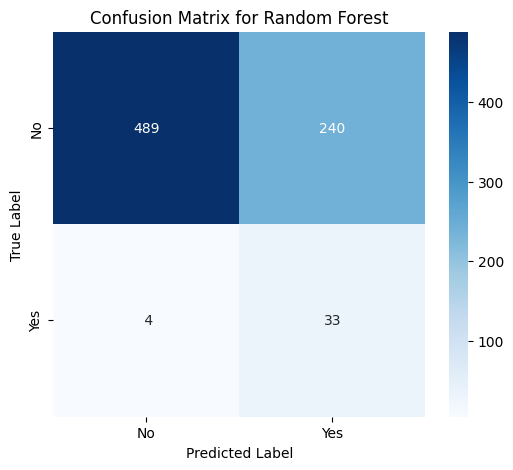

In [173]:
iv.plot_confusion(y_validation, y_pred_validation_rf, model_name="Random Forest")

### XGBoost

In [174]:
pipeline = Pipeline(steps=[
    ('imputer', GroupedMedianImputer(group_cols=['gender', 'age_bin'], target_col='bmi')),
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state=50, max_depth = 2))
])

param_distributions = {
    'classifier__n_estimators': randint(100, 350),
    'classifier__learning_rate': uniform(0.01, 0.1),
    'classifier__subsample': uniform(0.5, 0.3),
    'classifier__colsample_bytree': uniform(0.5, 0.5),
    'classifier__gamma': uniform(0, 5),
    'classifier__scale_pos_weight': [33, 34, 35, 36, 37]
}

random_search_xgb = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='recall',
    cv=stratified_cv,
    random_state=50,
    n_jobs=-1
)

random_search_xgb.fit(X_train, y_train)

print("Best parameters:", random_search_xgb.best_params_)
best_model = random_search_xgb.best_estimator_

C:\Users\inese\AppData\Local\Temp\ipykernel_4012\3894155599.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Best parameters: {'classifier__colsample_bytree': np.float64(0.5483073830418713), 'classifier__gamma': np.float64(0.8913678910964351), 'classifier__learning_rate': np.float64(0.013033942041203853), 'classifier__n_estimators': 120, 'classifier__scale_pos_weight': 37, 'classifier__subsample': np.float64(0.5782711819711472)}


In [175]:
results_df = pd.DataFrame(random_search_xgb.cv_results_)
param_cols = [col for col in results_df.columns if col.startswith('param_')]
iv.plot_parallel_coordinates(results_df, dimensions=param_cols)

In [176]:
best_xgb_model = random_search_xgb.best_estimator_
y_pred_validation_xgb = iv.evaluate_on_validation(
    best_xgb_model, X_validation, y_validation
)


Validation (or Test) Set Performance:
Accuracy: 0.5261
Recall: 0.9730
F1 Score: 0.1655


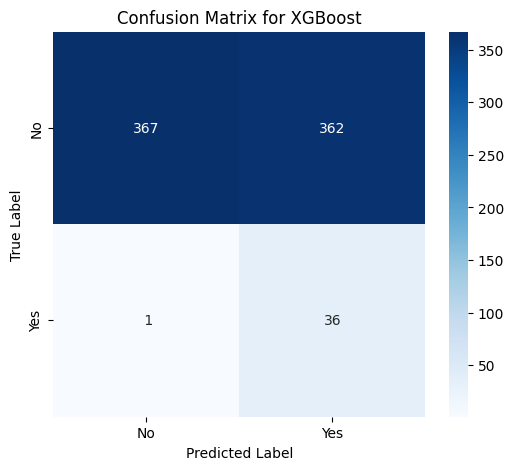

In [177]:
iv.plot_confusion(y_validation, y_pred_validation_xgb, model_name="XGBoost")

We get almost perfect true positive predictions, but on expense of many false positive predictions. Regarding this a decision has to be made - maybe additional non costly health checks (additional features) to distinguish patients from high risk group and low stroke risk group.

### CatBoost

I do not use one-hot encoding for CatBoost preporcessor because this affects both the training speed and the resulting quality.

In [59]:
categorical_features = [col for col in categorical_features if col != 'age_bin']

In [61]:
preprocessor_cat = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline_cat = Pipeline(steps=[
    ('imputer', GroupedMedianImputer(group_cols=['gender', 'age_bin'], target_col='bmi')),
    ('drop_age_bin', ColumnDropper(columns_to_drop=['age_bin'])),
    ('preprocessor', preprocessor_cat),  
    ('classifier', CatBoostClassifier(
        eval_metric='Recall',
        random_state=50,
        verbose=0
    ))
])

param_distributions = {
    'classifier__iterations': randint(100, 350),
    'classifier__learning_rate': uniform(0.01, 0.1),
    'classifier__depth': randint(2, 10),
    'classifier__l2_leaf_reg': uniform(1, 10),
    'classifier__scale_pos_weight': [33, 34, 35, 36, 37]
}

random_search_cat = RandomizedSearchCV(
    pipeline_cat,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='recall',
    cv=stratified_cv,
    random_state=50,
    n_jobs=-1
)

random_search_cat.fit(X_train, y_train)

print("Best parameters:", random_search_cat.best_params_)
best_model = random_search_cat.best_estimator_

C:\Users\inese\AppData\Local\Temp\ipykernel_6412\3894155599.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Best parameters: {'classifier__depth': 2, 'classifier__iterations': 118, 'classifier__l2_leaf_reg': np.float64(5.201768651139973), 'classifier__learning_rate': np.float64(0.015170204741891926), 'classifier__scale_pos_weight': 34}


In [62]:
results_df = pd.DataFrame(random_search_cat.cv_results_)
param_cols = [col for col in results_df.columns if col.startswith('param_')]
iv.plot_parallel_coordinates(results_df, dimensions=param_cols)

In [63]:
best_cat_model = random_search_cat.best_estimator_
y_pred_validation_cat = iv.evaluate_on_validation(
    best_cat_model, X_validation, y_validation
)


Validation (or Test) Set Performance:
Accuracy: 0.5901
Recall: 0.9730
F1 Score: 0.1865


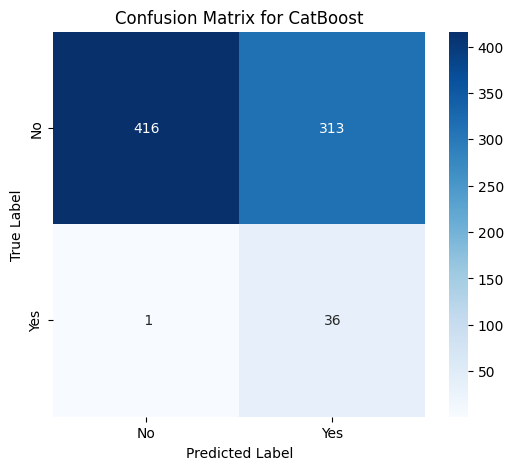

In [64]:
iv.plot_confusion(y_validation, y_pred_validation_cat, model_name="CatBoost")

### LightGBM

In [ ]:
pipeline = Pipeline(steps=[
    ('imputer', GroupedMedianImputer(group_cols=['gender', 'age_bin'], target_col='bmi')),
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        class_weight='balanced',
        random_state=50,
        n_jobs=-1
    ))
])

param_distributions = {
    'classifier__n_estimators': randint(100, 350),
    'classifier__learning_rate': uniform(0.01, 0.05),
    'classifier__num_leaves': randint(20, 150),
    'classifier__min_child_samples': randint(10, 100),
    'classifier__scale_pos_weight': [33, 34, 35, 36, 37]
}

random_search_light = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='recall',
    cv=stratified_cv,
    random_state=50,
    n_jobs=-1
)

random_search_light.fit(X_train, y_train)

print("Best parameters:", random_search_light.best_params_)
best_model = random_search_light.best_estimator_

C:\Users\inese\AppData\Local\Temp\ipykernel_4012\3894155599.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[LightGBM] [Info] Number of positive: 174, number of negative: 3403
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 3577, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best parameters: {'classifier__learning_rate': np.float64(0.011071811607969958), 'classifier__min_child_samples': 80, 'classifier__n_estimators': 122, 'classifier__num_leaves': 22, 'classifier__scale_pos_weight': 35}


In [183]:
results_df = pd.DataFrame(random_search_light.cv_results_)
param_cols = [col for col in results_df.columns if col.startswith('param_')]
iv.plot_parallel_coordinates(results_df, dimensions=param_cols)

In [184]:
best_light_model = random_search_light.best_estimator_
y_pred_validation_light = iv.evaluate_on_validation(
    best_light_model, X_validation, y_validation
)


Validation (or Test) Set Performance:
Accuracy: 0.5039
Recall: 0.9459
F1 Score: 0.1556


C:\Users\inese\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



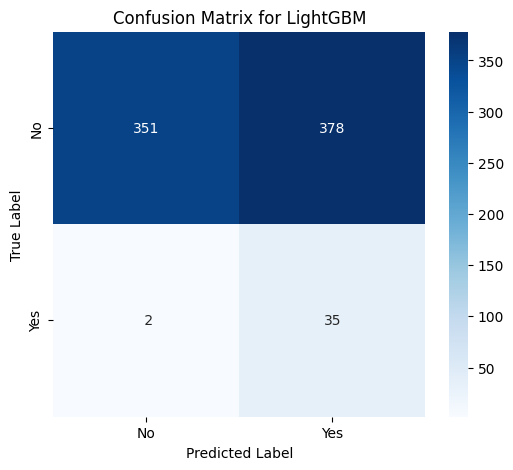

In [185]:
iv.plot_confusion(y_validation, y_pred_validation_light, model_name="LightGBM")

### Model ensemble

In [ ]:
svm_params = {k.split('__')[1]: v for k, v in random_search_svm.best_params_.items() if 'classifier__' in k}
xgb_params = {k.split('__')[1]: v for k, v in random_search_xgb.best_params_.items() if 'classifier__' in k}
light_params = {k.split('__')[1]: v for k, v in random_search_light.best_params_.items() if 'classifier__' in k}
cat_params = {k.split('__')[1]: v for k, v in random_search_cat.best_params_.items() if 'classifier__' in k}

svm_model = SVC(class_weight='balanced', probability=True, random_state=50, **svm_params)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=50, max_depth=2, **xgb_params)
light_model = LGBMClassifier(random_state=50, objective='binary', boosting_type='gbdt',
                             class_weight='balanced', n_jobs=-1, **light_params)
cat_model = CatBoostClassifier(random_state=50, verbose=0, eval_metric='Recall', **cat_params)

base_pipeline = Pipeline(steps=[
    ('imputer', GroupedMedianImputer(group_cols=['gender', 'age_bin'], target_col='bmi')),
    ('preprocessor', preprocessor)
])

def make_pipeline(model):
    return Pipeline(steps=[
        ('base', base_pipeline),
        ('classifier', model)
    ])

svm_pipeline = make_pipeline(svm_model)
xgb_pipeline = make_pipeline(xgb_model)
light_pipeline = make_pipeline(light_model)
cat_pipeline = make_pipeline(cat_model)

ensemble = VotingClassifier(
    estimators=[
        ('svm', svm_pipeline),
        ('xgb', xgb_pipeline),
        ('lgbm', light_pipeline),
        ('cat', cat_pipeline)
    ],
    voting='soft',
    n_jobs=-1
)

ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              Pipeline(steps=[('base',
                                               Pipeline(steps=[('imputer',
                                                                GroupedMedianImputer(group_cols=['gender',
                                                                                                 'age_bin'],
                                                                                     target_col='bmi')),
                                                               ('preprocessor',
                                                                ColumnTransformer(transformers=[('num',
                                                                                                 StandardScaler(),
                                                                                                 ['age',
                                                                                                  'bmi',
                                                                                                  'avg_glucose_level']),
                                                                                                ('cat',
                                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                                 ['hypertension',
                                                                                                  'heart_disease',
                                                                                                  'gende...
                                                                                                 ['hypertension',
                                                                                                  'heart_disease',
                                                                                                  'gender',
                                                                                                  'ever_married',
                                                                                                  'work_type',
                                                                                                  'Residence_type',
                                                                                                  'smoking_status'])]))])),
                                              ('classifier',
                                               LGBMClassifier(class_weight='balanced',
                                                              learning_rate=np.float64(0.011071811607969958),
                                                              min_child_samples=80,
                                                              n_estimators=122,
                                                              n_jobs=-1,
                                                              num_leaves=22,
                                                              objective='binary',
                                                              random_state=50,
                                                              scale_pos_weight=35))]))],
                 n_jobs=-1, voting='soft')

In [237]:
svm_params = {k.split('__')[1]: v for k, v in random_search_svm.best_params_.items() if 'classifier__' in k}
xgb_params = {k.split('__')[1]: v for k, v in random_search_xgb.best_params_.items() if 'classifier__' in k}
cat_params = {k.split('__')[1]: v for k, v in random_search_cat.best_params_.items() if 'classifier__' in k}

svm_model = SVC(class_weight='balanced', probability=True, random_state=50, **svm_params)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=50, max_depth=2, **xgb_params)
cat_model = CatBoostClassifier(random_state=50, verbose=0, eval_metric='Recall', **cat_params)

base_pipeline = Pipeline(steps=[
    ('imputer', GroupedMedianImputer(group_cols=['gender', 'age_bin'], target_col='bmi')),
    ('preprocessor', preprocessor)
])

def make_pipeline(model):
    return Pipeline(steps=[
        ('base', base_pipeline),
        ('classifier', model)
    ])

estimators = [
    ('svm', make_pipeline(svm_model)),
    ('xgb', make_pipeline(xgb_model)),
    ('cat', make_pipeline(cat_model))
]

final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')

ensemble = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    passthrough=False,
    n_jobs=-1
)

ensemble.fit(X_train, y_train)

StackingClassifier(estimators=[('svm',
                                Pipeline(steps=[('base',
                                                 Pipeline(steps=[('imputer',
                                                                  GroupedMedianImputer(group_cols=['gender',
                                                                                                   'age_bin'],
                                                                                       target_col='bmi')),
                                                                 ('preprocessor',
                                                                  ColumnTransformer(transformers=[('num',
                                                                                                   StandardScaler(),
                                                                                                   ['age',
                                                                                                    'bmi',
                                                                                                    'avg_glucose_level']),
                                                                                                  ('cat',
                                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                                   ['hypertension',
                                                                                                    'heart_disease',
                                                                                                    'gen...
                                                                                                   ['age',
                                                                                                    'bmi',
                                                                                                    'avg_glucose_level']),
                                                                                                  ('cat',
                                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                                   ['hypertension',
                                                                                                    'heart_disease',
                                                                                                    'gender',
                                                                                                    'ever_married',
                                                                                                    'work_type',
                                                                                                    'Residence_type',
                                                                                                    'smoking_status'])]))])),
                                                ('classifier',
                                                 <catboost.core.CatBoostClassifier object at 0x0000020B48A4D550>)]))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=1000),
                   n_jobs=-1)

In [238]:
y_pred_validation_ensemble = iv.evaluate_on_validation(
    ensemble, X_validation, y_validation
)


Validation (or Test) Set Performance:
Accuracy: 0.6802
Recall: 0.9189
F1 Score: 0.2173


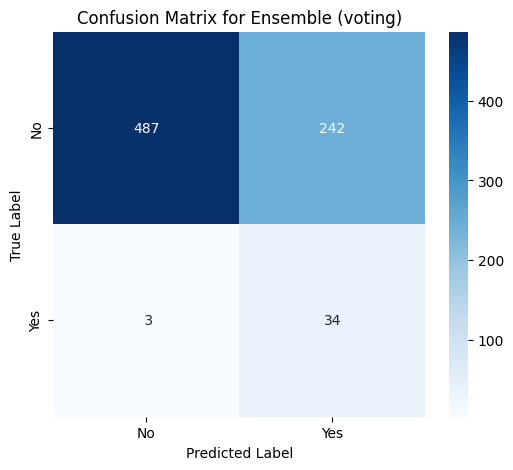

In [239]:
iv.plot_confusion(y_validation, y_pred_validation_ensemble, model_name="Ensemble (voting)")

### Cross-validation and summary of validation results

I have developed several models, including a baseline logistic regression model, decision tree, SVM, random forest, XGBoost, CatBoost, LightGBM and an ensembled model. In this section, I will summarize the recall, accuracy, precision, F1-score, ROC-AUC, and performance time for all models. My primary evaluation metric is recall, followed by F1-score as the secondary metric, and performance time as the third. These three metrics will guide the selection of the best-performing model. I will begin by summarizing the cross-validation results for all models.

In [244]:
models = {
    "Baseline": baseline,
    "Decision Tree": best_dtree_model,
    "SVM": best_svm_model,
    "Random Forest": best_rf_model,
    "XGBoost": best_xgb_model,	
    "CatBoost": best_cat_model,
    "LightGBM": best_light_model,
    "Ensemble": ensemble
}
warnings.filterwarnings("ignore", category=UserWarning)

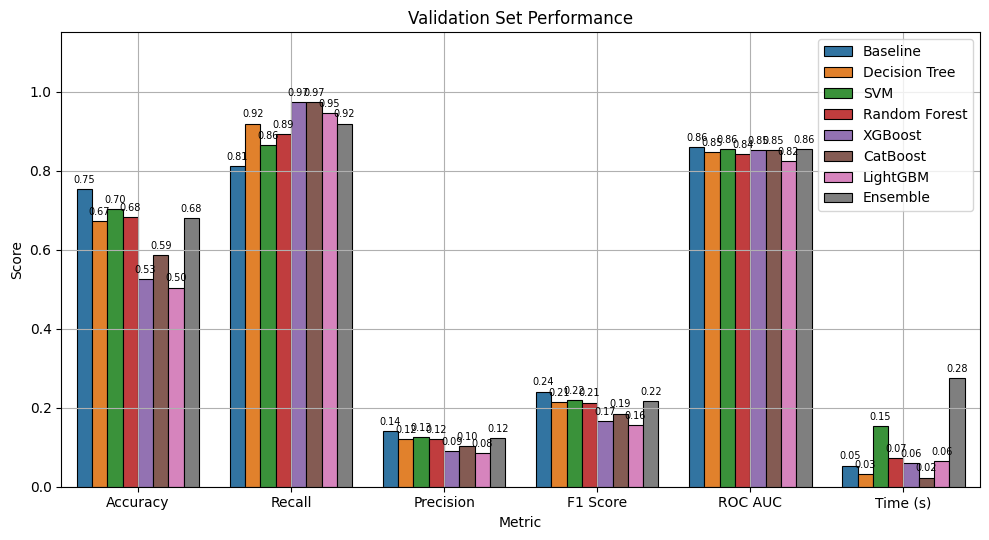

In [245]:
evaluate_validation = iv.evaluate_models_validation(
    models, X_validation, y_validation, figsize=(10, 5.5)
)

From the validation dataset results, the recall scores are quite similar across all models, with the XGBoost model and CatBoost model performing the best. In terms of F1-score, the CatBoost model is slightly better, it also has fastest fit times.

Overall, the models perform similarly, with only minor differences in performance. However, based on the primary metric—recall—I have chosen the CatBoost model as the best model. 

### Evaluating the CatBoost model

I will evaluate CatBoost model on test dataset.

In [65]:
y_pred_test_cat = iv.evaluate_on_validation(best_cat_model, X_test, y_test)


Validation (or Test) Set Performance:
Accuracy: 0.5984
Recall: 0.9474
F1 Score: 0.1895


The accuracy on test data (0.60) and on validation data (0.59) are close to each other. The recall on test data (0.95) and on validation data (0.97) are also similar which is a good sign.

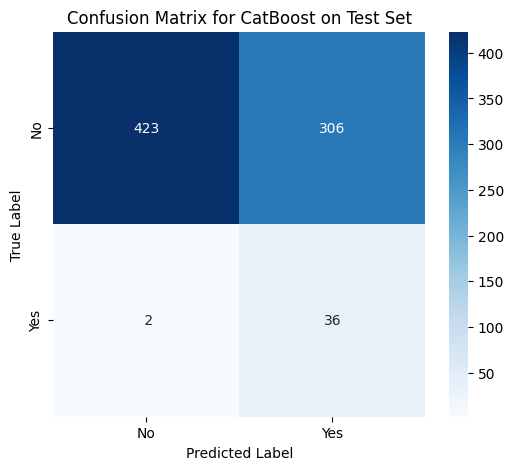

In [66]:
iv.plot_confusion(y_test, y_pred_test_cat, model_name="CatBoost on Test Set")

### Feature importance

I will check feature importance for this CatBoost model.

In [ ]:
catboost_model = best_cat_model.named_steps['classifier']
preprocessor = best_model.named_steps['preprocessor']
ohe = preprocessor.named_transformers_['cat'] 

ohe_feature_names = ohe.get_feature_names_out(categorical_features)

full_feature_names = list(numeric_features) + list(ohe_feature_names)

In [77]:
importances = catboost_model.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': full_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp_df.head(10))

                  Feature  Importance
0                     age   87.056639
1                     bmi    4.319523
2       avg_glucose_level    1.930345
6         heart_disease_1    1.212050
5         heart_disease_0    0.863097
3          hypertension_0    0.722589
14      work_type_Private    0.711335
11       ever_married_Yes    0.687409
10        ever_married_No    0.579219
22  smoking_status_smokes    0.318598


This code finds individual feature importances as computed by CatBoost, after one-hot encoding. To make feature importance interpretable, I will group them to original features.

In [78]:
feature_groups = {
    'heart_disease': ['heart_disease_0', 'heart_disease_1'],
    'ever_married': ['ever_married_Yes', 'ever_married_No'],
    'work_type': [col for col in feat_imp_df['Feature'] if col.startswith('work_type_')],
    'smoking_status': [col for col in feat_imp_df['Feature'] if col.startswith('smoking_status_')],
    'hypertension': ['hypertension_0', 'hypertension_1'], 
    'gender': [col for col in feat_imp_df['Feature'] if col.startswith('gender_')], 
    'Residence_type': [col for col in feat_imp_df['Feature'] if col.startswith('Residence_type_')]
}

grouped_importance = []
for group_name, columns in feature_groups.items():
    total_importance = feat_imp_df[feat_imp_df['Feature'].isin(columns)]['Importance'].sum()
    grouped_importance.append((group_name, total_importance))

numeric_features = ['age', 'bmi', 'avg_glucose_level']
for feature in numeric_features:
    total_importance = feat_imp_df[feat_imp_df['Feature'] == feature]['Importance'].sum()
    grouped_importance.append((feature, total_importance))

summary = pd.DataFrame(grouped_importance, columns=['Feature Group', 'Total Importance'])
summary = summary.sort_values('Total Importance', ascending=True)

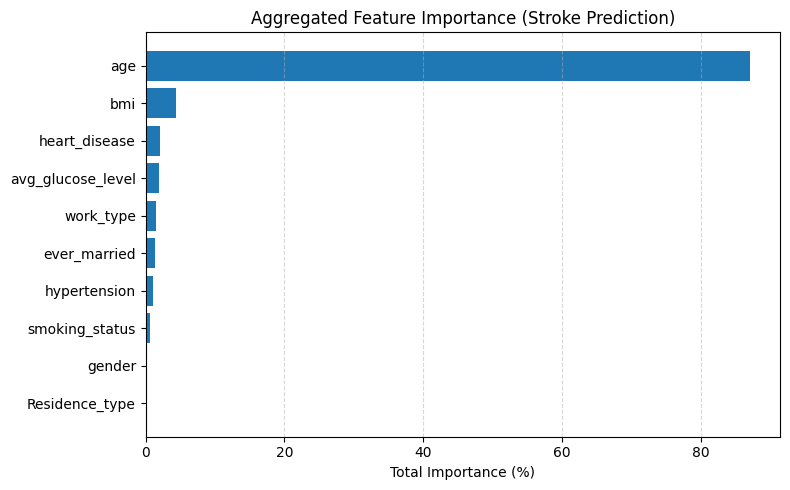

In [76]:
plt.figure(figsize=(8, 5))
plt.barh(summary['Feature Group'], summary['Total Importance'])
plt.xlabel('Total Importance (%)')
plt.title('Aggregated Feature Importance (Stroke Prediction)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [85]:
import joblib

# Suppose your model is called `model`
joblib.dump(best_cat_model, 'catboost_model.pkl')

['catboost_model.pkl']